# Path Planning

We move the robot in the direction of the point that is furthest away. Since our simulated Lidar has a range larger than the maximum distance for this race track we do not have to deal with None values.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from lidar_sim import LidarSumulator

In [3]:
lidar = LidarSumulator("piste.stl")

## Visualize the situation for a given pose

In [4]:
pose = [900, 50, np.pi]
#pose = [850, 52, 3.0892327760299634]
#pose = [800, 60, 2.9845130209103035]
#pose = [753, 77, 2.792526803190927]
#pose = [715, 110, 2.426007660272118]
#pose = [500, 50, np.pi + np.radians(-3)]
#pose = [ 166.648113,  213.283612,  0.20943951]
#pose = [ 215.555493,  223.679196,  0.20943951]
#pose = [260.735529, 234.518542, 0.2268928 ]
#pose = [107.199835, 189.184783, 1.30899694]
#pose = [100, 189.184783, 1.30899694]
#pose = [ 621.478646,  354.8938  , -0.80285146]

In [5]:
plot_scann = lidar.get_lidar_points(pose[0], pose[1], pose[2])
triangles = lidar.get_env_triangles(pose[0], pose[1], pose[2])

/Users/hdumcke/git/TRR2023/simulation/jupyternb/lidar_sim.py:76: RuntimeWarning: divide by zero encountered in scalar divide
  m = (r_s_2 - r_s_1) / (r_c_2 - r_c_1)
/Users/hdumcke/git/TRR2023/simulation/jupyternb/lidar_sim.py:78: RuntimeWarning: invalid value encountered in scalar divide
  dist = b / (np.sin(theta_plus) - m * np.cos(theta_plus))


In [6]:
def get_longest_distance(scann):
    view_angle = 60  # degrees
    sample_each_side = int(len(scann) / 360 * view_angle / 2)
    max_distance = 0
    max_index = 0
    for i in range(sample_each_side):
        if scann[i] is None:
            continue
        if scann[i] > max_distance:
            max_distance = scann[i]
            max_index = i
        if scann[-i] is None:
            continue
        if scann[-i] > max_distance:
            max_distance = scann[-i]
            max_index = -i

    return max_index

In [7]:
lidar_scann = lidar.lidar_scann(pose[0], pose[1], pose[2])
target_index = get_longest_distance(lidar_scann)
target_point = [np.radians(lidar.resolution) * target_index, lidar_scann[target_index]]

In [8]:
target_angle = np.radians(lidar.resolution) * target_index

In [9]:
target_line = np.stack(([0., 0.], target_point))

Text(0.5, 1.0, 'Lidar Scann')

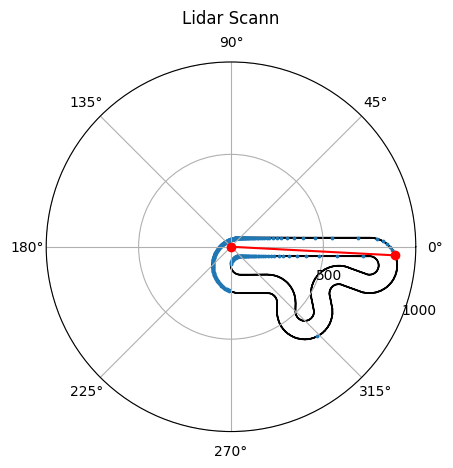

In [10]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
for t in triangles:
    ax.fill(t[:, 0],t[:, 1],fill=False)
ax.plot(target_line[:, 0], target_line[:, 1], 'ro-')
ax.scatter(plot_scann[:, 0], plot_scann[:, 1], s=3.0)
ax.set_rmax(1000)
ax.set_rticks([500, 1000])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("Lidar Scann", va='bottom')

## Calculate a path and visualize

In [11]:
def calc_cmd_vel(pose, lidar):
    vel_max = 1.0 # m/sec
    lidar_scann = lidar.lidar_scann(pose[0] * 100, pose[1] * 100, pose[2])
    target_index = get_longest_distance(lidar_scann)
    # angel in map coordinate system
    angular_z = pose[2] + np.radians(lidar.resolution) * target_index
    linear_x = vel_max
    return {"linear_x": linear_x, "angular_z": angular_z}

In [12]:
def get_odom(cmd_vel, pose, dt):
    x = pose[0] + cmd_vel["linear_x"] * np.cos(cmd_vel["angular_z"]) * dt
    y = pose[1] + cmd_vel["linear_x"] * np.sin(cmd_vel["angular_z"]) * dt
    return [x, y, cmd_vel["angular_z"]]

In [13]:
way_points = []
dt = 0.1
pose = [9, 0.5, np.pi]
way_points.append(pose)
for i in range(200):
    pose = get_odom(calc_cmd_vel(pose, lidar), pose, dt)
    way_points.append(pose)

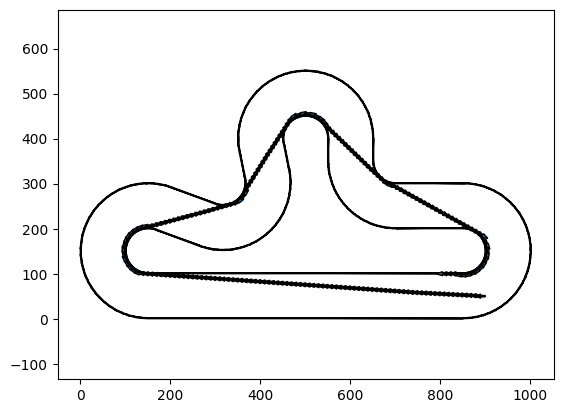

In [14]:
path = np.array(way_points)
triangles = lidar.get_map_triangles()

fig, ax = plt.subplots(1, 1)
ax.axis('equal')
for t in triangles:
    ax.fill(t[:, 0],t[:, 1],fill=False)
for i in range(path.shape[0]):
    ax.arrow(path[i, 0] * 100, path[i, 1] * 100, 10 * np.cos(path[i, 2]), 10 * np.sin(path[i, 2]), width=3.0)